# Proyecto de Minería de Datos: GymPredict
- Carlos Beytía
- Nicolás Nazar
- Vicente Olmos

## Descripción del Proyecto
Este proyecto tiene como objetivo analizar y predecir los mejores horarios para ir al gimnasio, basándonos en los datos de aforo recopilados durante un período de tiempo. La idea es proporcionar recomendaciones de cuándo el gimnasio es menos concurrido para que los usuarios puedan planificar sus visitas de manera más eficiente.


## Carga de datos

In [1]:
import pandas as pd
df_aforo = pd.read_csv('aforo_final.csv', delimiter=';')
df_aforo

,aforo,Lunes,Martes,Miercoles,Jueves,Viernes,Sabado,Domingo,Hora
0,211,0,0,0,1,0,0,0,20:36:00
1,212,0,0,0,1,0,0,0,20:37:00
2,211,0,0,0,1,0,0,0,20:41:00
3,210,0,0,0,1,0,0,0,20:43:00
4,212,0,0,0,1,0,0,0,20:46:00
...,...,...,...,...,...,...,...,...,...
14607,41,0,0,0,1,0,0,0,22:57:00
14608,33,0,0,0,1,0,0,0,22:58:00
14609,29,0,0,0,1,0,0,0,22:59:00
14610,26,0,0,0,1,0,0,0,23:00:00


## Análisis Exploratorio
Se puede observar que la tendencia a simple vista es de forma en "M" siendo las hora peak a las 10:00 y a las 20:00 aproximadamente.

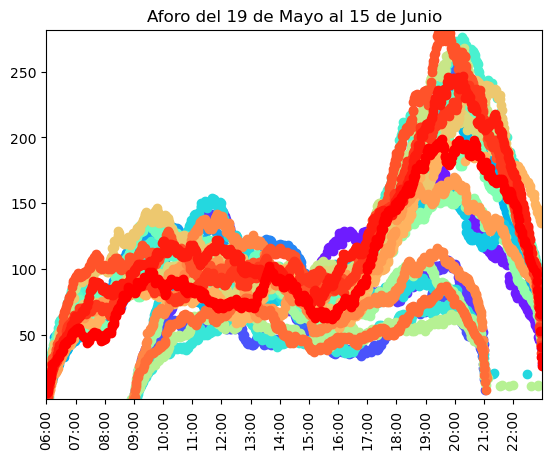

In [5]:
import os
import csv
import matplotlib.pyplot as plt
from matplotlib import cm
from datetime import datetime, time
import numpy as np

def convertir_a_minutos_desde_6AM(hora):
    return (hora.hour - 6) * 60 + hora.minute

directorio = os.path.join(os.getcwd(), "Aforos")
archivos_csv = [f for f in os.listdir(directorio) if f.endswith('.csv')]

colores = cm.rainbow(np.linspace(0, 1, len(archivos_csv)))

aforo_menor = float('inf')
aforo_mayor = float('-inf')

plt.figure()

for i, archivo in enumerate(archivos_csv):
    minutos_desde_6AM = []
    aforos = []
    with open(os.path.join(directorio, archivo), 'r') as f:
        reader = csv.reader(f, delimiter=';')
        next(reader)  
        for row in reader:
            aforo = float(row[0])
            hora = datetime.strptime(row[1], "%Y-%m-%d %H:%M:%S").time()
            if time(6, 0) <= hora <= time(23, 0):
                minutos_desde_6AM.append(convertir_a_minutos_desde_6AM(hora))
                aforos.append(aforo)
            aforo_menor = min(aforo_menor, aforo)
            aforo_mayor = max(aforo_mayor, aforo)
    plt.plot(minutos_desde_6AM, aforos, marker='o', linestyle='', color=colores[i])  

plt.ylim(aforo_menor, aforo_mayor)
plt.xlim(0, (23-6)*60)  

# Ajustar etiquetas del eje x para mostrar horas en lugar de minutos
etiquetas = [time(hour=h).strftime('%H:%M') for h in range(6, 23)] # ajustado hasta 23 (22:00)
plt.xticks(np.arange(0, (23-6)*60, 60), etiquetas, rotation=90)

plt.title("Aforo del 19 de Mayo al 15 de Junio")
plt.show()

## Entrenamiento, Visualización y Evaluación
### Regresión Polinomial

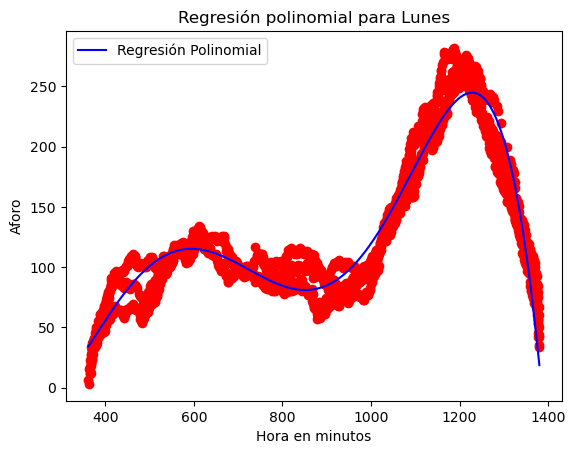

Para Lunes, el intervalo de 60 minutos con el menor aforo esperado comienza a las 13:41


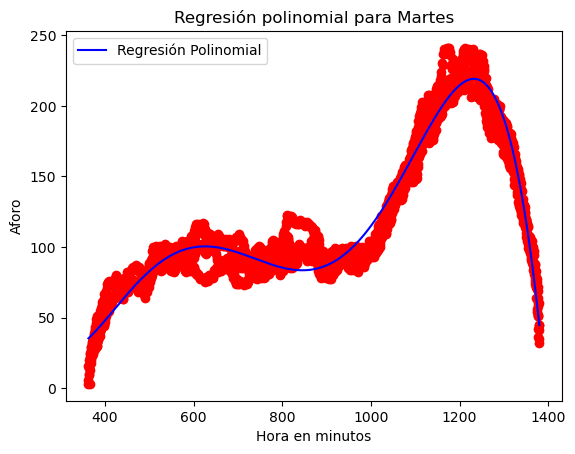

Para Martes, el intervalo de 60 minutos con el menor aforo esperado comienza a las 7:33


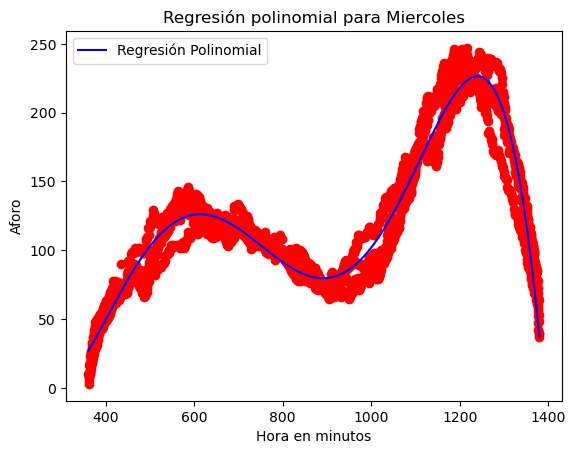

Para Miercoles, el intervalo de 60 minutos con el menor aforo esperado comienza a las 14:21


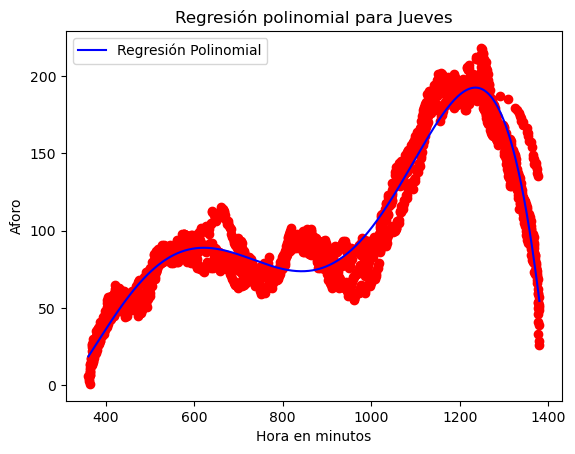

No se encontró un intervalo de 60 minutos para Jueves dentro del horario de apertura con los buffers especificados.


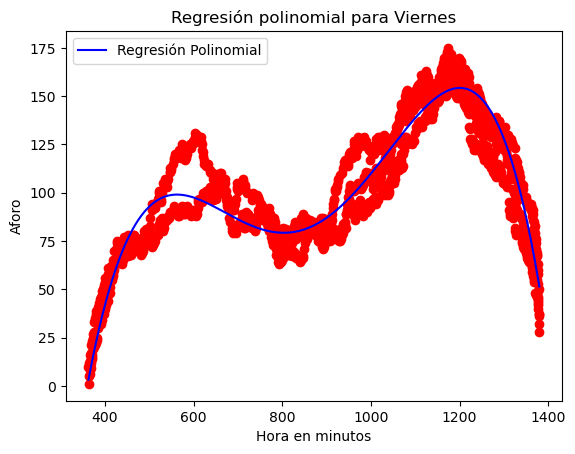

Para Viernes, el intervalo de 60 minutos con el menor aforo esperado comienza a las 12:53


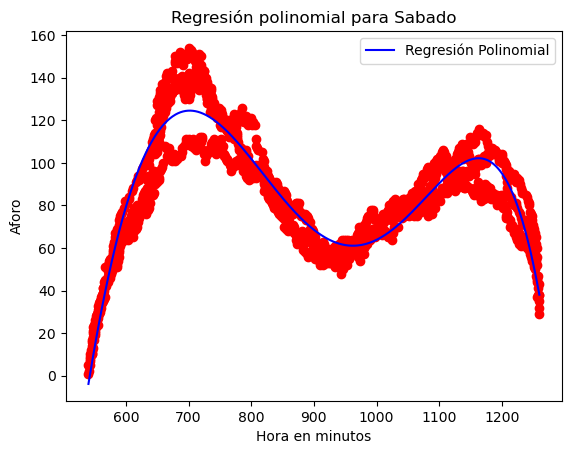

Para Sabado, el intervalo de 60 minutos con el menor aforo esperado comienza a las 15:33


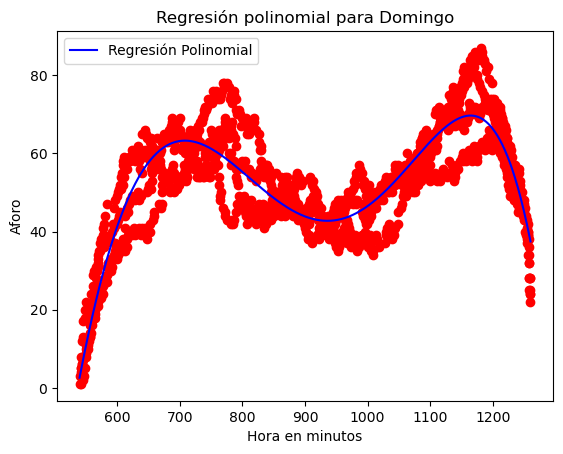

Para Domingo, el intervalo de 60 minutos con el menor aforo esperado comienza a las 15:06


El error cuadrático medio promedio es 167.74
El coeficiente de determinación promedio es 0.87
El error absoluto medio promedio es 9.84


In [15]:
import pandas as pd
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression
import matplotlib.pyplot as plt
import numpy as np
from scipy import integrate as spi

def windowed_min_area(X, y_pred, window=60, start_buffer=90, end_buffer=60):
    min_area = np.inf
    min_start = None

    start_time = int(X[0] + start_buffer)
    end_time = int(X[-1] - end_buffer)

    if end_time - start_time < window:
        return None, None

    for start in range(start_time, end_time-window+1):
        end = start + window
        interval_X = np.array(range(start, end)).reshape(-1, 1)
        interval_y_pred = pol_reg.predict(poly.transform(interval_X))
        area = spi.trapz(interval_y_pred, interval_X.flatten())
        if area < min_area:
            min_area = area
            min_start = start

    return min_start, min_area

data = pd.read_csv('aforo_final.csv', delimiter=';')
data['MinutosDesdeApertura'] = data['Hora'].apply(lambda x: int(x.split(':')[0])*60 + int(x.split(':')[1]))

for dia in ['Lunes', 'Martes', 'Miercoles', 'Jueves', 'Viernes']:
    data_dia = data[(data[dia] == 1) & (data['MinutosDesdeApertura'] >= 6*60) & (data['MinutosDesdeApertura'] <= 23*60)]

    X = data_dia['MinutosDesdeApertura'].values.reshape(-1,1)
    y = data_dia['aforo']

    poly = PolynomialFeatures(degree=5)
    X_poly = poly.fit_transform(X)

    pol_reg = LinearRegression()
    pol_reg.fit(X_poly, y)

    plt.scatter(X, y, color='red')
    sorted_zip = sorted(zip(X, pol_reg.predict(X_poly)))
    X_plot, y_plot = zip(*sorted_zip)
    plt.plot(X_plot, y_plot, color='blue', label='Regresión Polinomial')
    plt.title('Regresión polinomial para ' + dia)
    plt.xlabel('Hora en minutos')
    plt.ylabel('Aforo')
    plt.legend()
    plt.show()

    min_start, min_area = windowed_min_area(X, pol_reg.predict(X_poly))
    if min_start is None:
        print(f"No se encontró un intervalo de 60 minutos para {dia} dentro del horario de apertura con los buffers especificados.")
        continue
    min_start_hour = min_start // 60
    min_start_minute = min_start % 60
    print(f"Para {dia}, el intervalo de 60 minutos con el menor aforo esperado comienza a las {min_start_hour}:{min_start_minute:02d}")

for dia in ['Sabado', 'Domingo']:
    data_dia = data[(data[dia] == 1) & (data['MinutosDesdeApertura'] >= 9*60) & (data['MinutosDesdeApertura'] <= 21*60)]

    X = data_dia['MinutosDesdeApertura'].values.reshape(-1,1)
    y = data_dia['aforo']

    poly = PolynomialFeatures(degree=5)
    X_poly = poly.fit_transform(X)

    pol_reg = LinearRegression()
    pol_reg.fit(X_poly, y)

    plt.scatter(X, y, color='red')
    sorted_zip = sorted(zip(X, pol_reg.predict(X_poly)))
    X_plot, y_plot = zip(*sorted_zip)
    plt.plot(X_plot, y_plot, color='blue',label='Regresión Polinomial')
    plt.title('Regresión polinomial para ' + dia)
    plt.xlabel('Hora en minutos')
    plt.ylabel('Aforo')
    plt.legend()
    plt.show()

    min_start, min_area = windowed_min_area(X, pol_reg.predict(X_poly))
    if min_start is None:
        print(f"No se encontró un intervalo de 60 minutos para {dia} dentro del horario de apertura con los buffers especificados.")
        continue
    min_start_hour = min_start // 60
    min_start_minute = min_start % 60
    print(f"Para {dia}, el intervalo de 60 minutos con el menor aforo esperado comienza a las {min_start_hour}:{min_start_minute:02d}")
    
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error

mse_values = []
r2_values = []
mae_values = []

for dia in ['Lunes', 'Martes', 'Miercoles', 'Jueves', 'Viernes', 'Sabado', 'Domingo']:
    data_dia = data[(data[dia] == 1) & (data['MinutosDesdeApertura'] >= 6*60) & (data['MinutosDesdeApertura'] <= 23*60)]

    X = data_dia['MinutosDesdeApertura'].values.reshape(-1,1)
    y = data_dia['aforo']

    poly = PolynomialFeatures(degree=5)
    X_poly = poly.fit_transform(X)

    pol_reg = LinearRegression()
    pol_reg.fit(X_poly, y)

    y_pred = pol_reg.predict(X_poly)

    mse = mean_squared_error(y, y_pred)
    r2 = r2_score(y, y_pred)
    mae = mean_absolute_error(y, y_pred)

    mse_values.append(mse)
    r2_values.append(r2)
    mae_values.append(mae)
print('\n')
print(f"El error cuadrático medio promedio es {np.mean(mse_values):.2f}")
print(f"El coeficiente de determinación promedio es {np.mean(r2_values):.2f}")
print(f"El error absoluto medio promedio es {np.mean(mae_values):.2f}")


### SVR

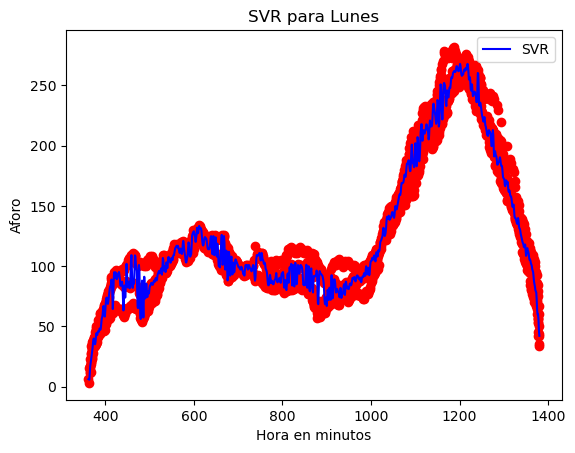

Para Lunes, el intervalo de 60 minutos con el menor aforo esperado comienza a las 14:53


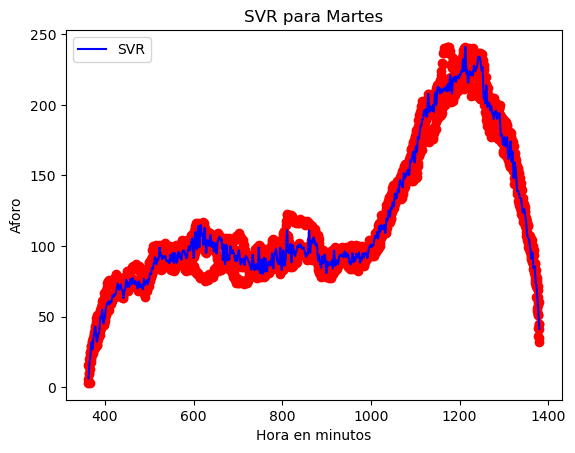

Para Martes, el intervalo de 60 minutos con el menor aforo esperado comienza a las 7:33


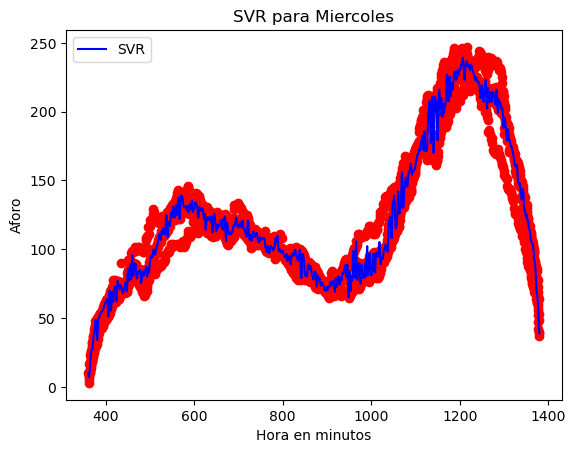

Para Miercoles, el intervalo de 60 minutos con el menor aforo esperado comienza a las 14:35


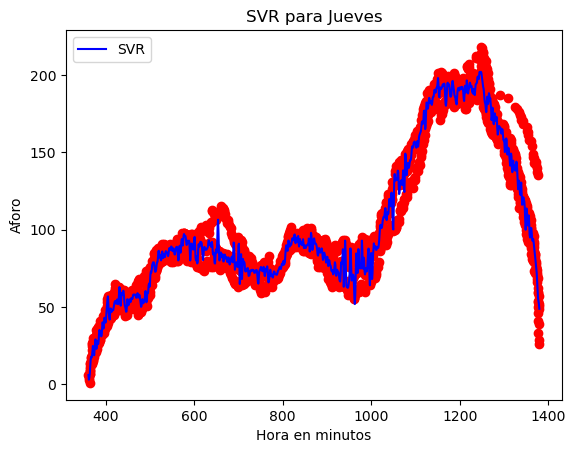

No se encontró un intervalo de 60 minutos para Jueves dentro del horario de apertura con los buffers especificados.


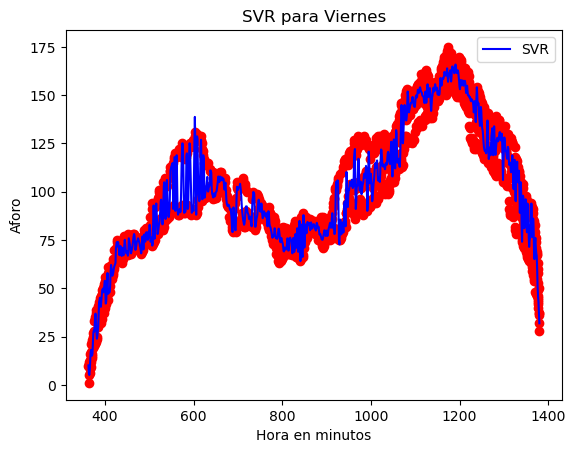

Para Viernes, el intervalo de 60 minutos con el menor aforo esperado comienza a las 13:08


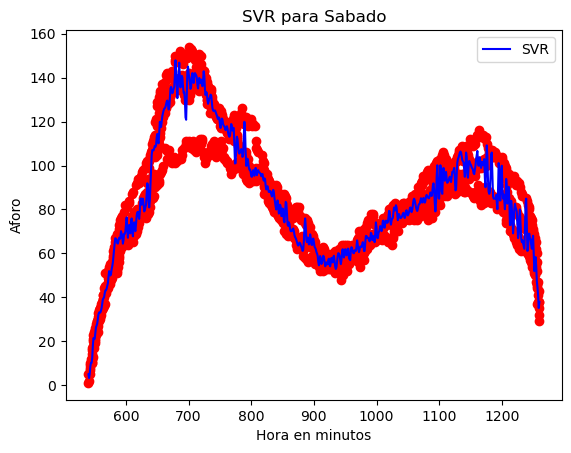

Para Sabado, el intervalo de 60 minutos con el menor aforo esperado comienza a las 15:05


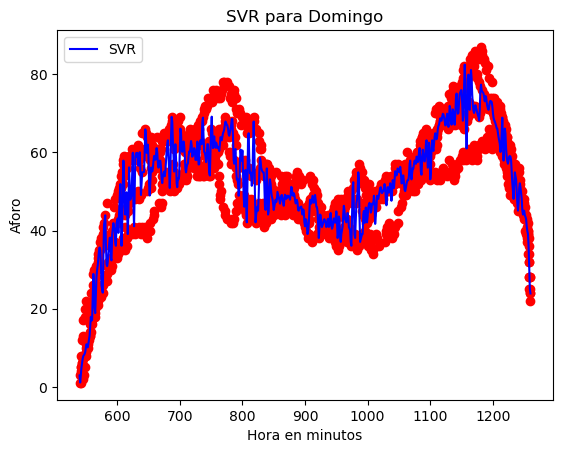

Para Domingo, el intervalo de 60 minutos con el menor aforo esperado comienza a las 15:17


El promedio del error cuadrático medio para todos los días es 87.58
El promedio del coeficiente de determinación para todos los días es 0.93
El promedio del error absoluto medio para todos los días es 5.86


In [19]:
import pandas as pd
from sklearn.svm import SVR
import matplotlib.pyplot as plt
import numpy as np
from scipy import integrate as spi

def windowed_min_area(X, y_pred, window=60, start_buffer=90, end_buffer=60):
    min_area = np.inf
    min_start = None

    start_time = int(X[0] + start_buffer)
    end_time = int(X[-1] - end_buffer)

    if end_time - start_time < window:
        return None, None

    for start in range(start_time, end_time-window+1):
        end = start + window
        interval_X = np.array(range(start, end)).reshape(-1, 1)
        interval_y_pred = svr_rbf.predict(interval_X)
        area = spi.trapz(interval_y_pred, interval_X.flatten())
        if area < min_area:
            min_area = area
            min_start = start
    
    return min_start, min_area


data = pd.read_csv('aforo_final.csv', delimiter=';')
data['MinutosDesdeApertura'] = data['Hora'].apply(lambda x: int(x.split(':')[0])*60 + int(x.split(':')[1]))

svr_rbf = SVR(kernel='rbf', C=1e3, gamma=0.1)

for dia in ['Lunes', 'Martes', 'Miercoles', 'Jueves', 'Viernes']:
    data_dia = data[(data[dia] == 1) & (data['MinutosDesdeApertura'] >= 6*60) & (data['MinutosDesdeApertura'] <= 23*60)]
    X = data_dia['MinutosDesdeApertura'].values.reshape(-1,1)
    y = data_dia['aforo']

    svr_rbf.fit(X, y)

    plt.scatter(X, y, color='red')
    sorted_zip = sorted(zip(X, svr_rbf.predict(X)))
    X_plot, y_plot = zip(*sorted_zip)
    plt.plot(X_plot, y_plot, color='blue', label='SVR')
    plt.title('SVR para ' + dia)
    plt.xlabel('Hora en minutos')
    plt.ylabel('Aforo')
    plt.legend()
    plt.show()

    y_pred = svr_rbf.predict(X)
    min_start, min_area = windowed_min_area(X, y_pred)
    if min_start is None:
        print(f"No se encontró un intervalo de 60 minutos para {dia} dentro del horario de apertura con los buffers especificados.")
        continue
    min_start_hour = min_start // 60
    min_start_minute = min_start % 60
    print(f"Para {dia}, el intervalo de 60 minutos con el menor aforo esperado comienza a las {min_start_hour}:{min_start_minute:02d}")

for dia in ['Sabado', 'Domingo']:
    data_dia = data[(data[dia] == 1) & (data['MinutosDesdeApertura'] >= 9*60) & (data['MinutosDesdeApertura'] <= 21*60)]
    X = data_dia['MinutosDesdeApertura'].values.reshape(-1,1)
    y = data_dia['aforo']

    svr_rbf.fit(X, y)

    plt.scatter(X, y, color='red')
    sorted_zip = sorted(zip(X, svr_rbf.predict(X)))
    X_plot, y_plot = zip(*sorted_zip)
    plt.plot(X_plot, y_plot, color='blue', label='SVR')
    plt.title('SVR para ' + dia)
    plt.xlabel('Hora en minutos')
    plt.ylabel('Aforo')
    plt.legend()
    plt.show()

    y_pred = svr_rbf.predict(X)
    min_start, min_area = windowed_min_area(X, y_pred)
    if min_start is None:
        print(f"No se encontró un intervalo de 60 minutos para {dia} dentro del horario de apertura con los buffers especificados.")
        continue
    min_start_hour = min_start // 60
    min_start_minute = min_start % 60
    print(f"Para {dia}, el intervalo de 60 minutos con el menor aforo esperado comienza a las {min_start_hour}:{min_start_minute:02d}")

from sklearn.svm import SVR
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error

mse_values = []
r2_values = []
mae_values = []

for dia in ['Lunes', 'Martes', 'Miercoles', 'Jueves', 'Viernes', 'Sabado', 'Domingo']:
    data_dia = data[(data[dia] == 1) & (data['MinutosDesdeApertura'] >= 6*60) & (data['MinutosDesdeApertura'] <= 23*60)]

    X = data_dia['MinutosDesdeApertura'].values.reshape(-1,1)
    y = data_dia['aforo']

    svr_rbf = SVR(kernel='rbf', C=1e3, gamma=0.1)
    svr_rbf.fit(X, y)

    y_pred = svr_rbf.predict(X)

    mse_values.append(mean_squared_error(y, y_pred))
    r2_values.append(r2_score(y, y_pred))
    mae_values.append(mean_absolute_error(y, y_pred))
print('\n')
print(f"El promedio del error cuadrático medio para todos los días es {np.mean(mse_values):.2f}")
print(f"El promedio del coeficiente de determinación para todos los días es {np.mean(r2_values):.2f}")
print(f"El promedio del error absoluto medio para todos los días es {np.mean(mae_values):.2f}")



## Conclusiones
Tras la implementación y evaluación de dos tipos de modelos de regresión, un modelo basado en Regresión Polinomial y otro en Máquinas de Vectores de Soporte (SVM), se observaron diferencias significativas en las métricas de error. El modelo basado en SVM proporcionó en promedio un Error Cuadrático Medio (MSE) de 87.58 y un Error Absoluto Medio (MAE) de 5.86, lo que indica una precisión superior al modelo de Regresión Polinomial, que arrojó un MSE de 167.74 y un MAE de 9.84.

No obstante, a pesar de la mayor precisión de las predicciones de SVM, la Regresión Polinomial se presenta como una opción más atractiva para este contexto. En el problema de predicción de aforo de un gimnasio, un grado extremadamente elevado de precisión en las predicciones no es el factor más crítico. Las predicciones razonablemente precisas, que ambos modelos proporcionan, son suficientes para las recomendaciones operativas necesarias.

Además, la Regresión Polinomial ofrece ventajas en términos de eficiencia computacional. Su menor demanda en recursos para entrenamiento y predicción la hacen una opción más factible a gran escala. Si se contempla la implementación de este modelo para todos los gimnasios a nivel nacional, el ahorro en costos y recursos computacionales podría ser significativo.

Por último, cabe destacar que ambos modelos sugirieron horas de operación similares, lo que indica un acuerdo general en las recomendaciones prácticas, independientemente de las diferencias en la precisión de las predicciones. Por lo tanto, consideramos que la Regresión Polinomial es una opción más adecuada para este contexto, a pesar de su mayor error promedio, debido a su eficiencia computacional y su facilidad de implementación.